In [69]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, col, count, when
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
spark = SparkSession.builder \
    .appName("Create DataFrames from Logs") \
    .getOrCreate()

file_paths_http = ["./data/task1/00/http.log.gz", "./data/task1/01/http.log.gz", "./data/task1/02/http.log.gz",
                   "./data/task1/03/http.log.gz", "./data/task1/04/http.log.gz", "./data/task1/05/http.log.gz"]

file_paths_dns = ["./data/task1/00/dns.log.gz", "./data/task1/01/dns.log.gz", "./data/task1/02/dns.log.gz",
                  "./data/task1/03/dns.log.gz", "./data/task1/04/dns.log.gz", "./data/task1/05/dns.log.gz"]

df_http = spark.read.json(file_paths_http)

df_dns = spark.read.json(file_paths_dns)

df_http.printSchema()
df_dns.printSchema()

df_http.show(5, truncate=True)
df_dns.show(5, truncate=True)

root
 |-- host: string (nullable = true)
 |-- id.orig_h: string (nullable = true)
 |-- id.orig_p: long (nullable = true)
 |-- id.resp_h: string (nullable = true)
 |-- id.resp_p: long (nullable = true)
 |-- method: string (nullable = true)
 |-- orig_filenames: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- orig_fuids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- orig_mime_types: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- origin: string (nullable = true)
 |-- proxied: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- referrer: string (nullable = true)
 |-- request_body_len: long (nullable = true)
 |-- resp_filenames: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- resp_fuids: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- resp_mime_types: array (nullable = true)
 |    |-- element: string (containsNull = true)

In [37]:
df_http = df_http.withColumn("ts", to_timestamp(df_http["ts"]))
df_dns = df_dns.withColumn("ts", to_timestamp(df_dns["ts"]))

df_http.show(5)
df_dns.show(5)

+---------------+---------------+---------+---------------+---------+------+--------------+--------------------+---------------+------+-------+--------------------+----------------+--------------+--------------------+---------------+-----------------+-----------+-----------------+----+-----------+--------------------+------------------+--------------------+--------------------+--------+-------+
|           host|      id.orig_h|id.orig_p|      id.resp_h|id.resp_p|method|orig_filenames|          orig_fuids|orig_mime_types|origin|proxied|            referrer|request_body_len|resp_filenames|          resp_fuids|resp_mime_types|response_body_len|status_code|       status_msg|tags|trans_depth|                  ts|               uid|                 uri|          user_agent|username|version|
+---------------+---------------+---------+---------------+---------+------+--------------+--------------------+---------------+------+-------+--------------------+----------------+--------------+--------

In [38]:
df_http.createOrReplaceTempView("http_log")
df_dns.createOrReplaceTempView("dns_log")


In [39]:
http_log_filtered = spark.sql("""
    select 
        uri, 
        count(*) as accessed_count
    from 
        http_log
    where 
        status_code = 200 and method = 'GET'
    group by 
        uri
    order by 
        accessed_count desc
""")

http_log_filtered.show()
print(http_log_filtered.count())

+--------------------+--------------+
|                 uri|accessed_count|
+--------------------+--------------+
|                   /|          9475|
|/admin/config.php...|           556|
|  /main.php?logout=1|           194|
|/top.php?stuff=15...|           191|
|            /top.php|           179|
|/main.php?stuff=1...|           172|
|  /get_latest_id.php|           159|
|/admin/config.php...|           138|
|    /cacti/index.php|           129|
|/en-US/api/messag...|           118|
|          /index.php|           105|
|/phpmyadmin/index...|            77|
|             /cacti/|            68|
|        /phpmyadmin/|            56|
|        /favicon.ico|            55|
|              /admin|            42|
|  /scripts/index.php|            40|
|             /icons/|            39|
|/en-US/api/search...|            39|
|  /cgi-bin/index.php|            37|
+--------------------+--------------+
only showing top 20 rows



7369


In [41]:
spark.sql("""
select 
    h.uid,
    d.uid,
    d.proto
from
    http_log h, 
    dns_log d
where
    trim(h.uid) = trim(d.uid)
""").show()


+------------------+------------------+-----+
|               uid|               uid|proto|
+------------------+------------------+-----+
| C1odva1GOl62Mubql| C1odva1GOl62Mubql|  udp|
| CQLw22eZ8JIDpJcik| CQLw22eZ8JIDpJcik|  udp|
|CKaLaf1peiUU3kmTV8|CKaLaf1peiUU3kmTV8|  udp|
|CtEYyv1YQSocDA5oY6|CtEYyv1YQSocDA5oY6|  udp|
|CwrlVC14uolzZt7dPc|CwrlVC14uolzZt7dPc|  udp|
| CzIyt32dXmMFfK0cI| CzIyt32dXmMFfK0cI|  udp|
|Cvhzsd2JH09vFeDbJk|Cvhzsd2JH09vFeDbJk|  udp|
|CPUpzb4oqzPYQZxnF7|CPUpzb4oqzPYQZxnF7|  udp|
|CFWPlA4sGS8yUlrM7e|CFWPlA4sGS8yUlrM7e|  udp|
| CFDlRY1TJ52tSimA6| CFDlRY1TJ52tSimA6|  udp|
|CxWRZL3Ho8bdyWEiwk|CxWRZL3Ho8bdyWEiwk|  udp|
|C0cFv53bfGO02GQsma|C0cFv53bfGO02GQsma|  udp|
| CscT2UI8EmU58fDuk| CscT2UI8EmU58fDuk|  udp|
| CUYrwDbRuXBxapQFa| CUYrwDbRuXBxapQFa|  udp|
|CeiomQ3qdeS3ESqe99|CeiomQ3qdeS3ESqe99|  udp|
|ClveGS2nXhopfdBvoa|ClveGS2nXhopfdBvoa|  udp|
| CxdESvjdAKHMAAvFg| CxdESvjdAKHMAAvFg|  udp|
| CqNa6ry5SSxMwkhYc| CqNa6ry5SSxMwkhYc|  udp|
|CoEJEF1ByMpkdNrZEd|CoEJEF1ByMpkdN

In [59]:
merged_df = spark.sql("""
    select 
        *
    from
        http_log h, 
        dns_log d
    where
        h.uid = d.uid
""")
merged_df = merged_df.drop(col("d.uid"))
merged_df.show()

+---------------+---------------+---------+---------------+---------+------+--------------+--------------------+---------------+------+-------+--------------------+----------------+--------------+--------------------+---------------+-----------------+-----------+-----------------+----+-----------+--------------------+------------------+--------------------+--------------------+--------+-------+-----+-----+----+-----+----+---+-------+--------------+---------+-------------+---------+-----+------+-----------+-----+----------+-------------------+-----+----------+--------+----+--------+--------------------+
|           host|      id.orig_h|id.orig_p|      id.resp_h|id.resp_p|method|orig_filenames|          orig_fuids|orig_mime_types|origin|proxied|            referrer|request_body_len|resp_filenames|          resp_fuids|resp_mime_types|response_body_len|status_code|       status_msg|tags|trans_depth|                  ts|               uid|                 uri|          user_agent|username|v

In [68]:
merged_df.select(["proto"]).dropDuplicates().show()

+-----+
|proto|
+-----+
|  udp|
+-----+



In [65]:
grouped_df = merged_df.groupBy("uri", "proto").agg(count("*").alias("count"))
tcp_df = grouped_df.filter(grouped_df["proto"] == "tcp")
tcp_df.show()
# total_counts = grouped_df.groupBy("uri").agg(count("*").alias("total_count"))
# joined_df = tcp_df.join(total_counts, "uri")
# result_df = joined_df.withColumn("tcp_percentage", (col("count") / col("total_count")) * 100)
# result_df = result_df.select("uri", "tcp_percentage")
# result_df.show()


+---+-----+-----+
|uri|proto|count|
+---+-----+-----+
+---+-----+-----+



+-----------+------+--------------------+
|     method| count|          percentage|
+-----------+------+--------------------+
|       some|    17|0.009147358565694177|
|     RDWWEM|     1|5.380799156290692E-4|
|    OPTIONS|  2388|  1.2849348385222175|
|     NESSUS|    13|0.006995038903177901|
|       POST| 40184|  21.622203329638516|
|       NULL|  1376|  0.7403979639055993|
|     DELETE|    22|0.011837758143839522|
|     Secure|    17|0.009147358565694177|
|   GNUTELLA|    34|0.018294717131388354|
|     MCPWYV|     1|5.380799156290692E-4|
|        PUT|    23|0.012375838059468592|
|   PROPFIND|    40| 0.02152319662516277|
|      TRACK|    13|0.006995038903177901|
|       HEAD|  4805|   2.585473994597678|
|      TRACE|    23|0.012375838059468592|
|        GET|136678|   73.54368670834992|
|     SEARCH|    72|0.038741753925292985|
|     EAILCX|     1|5.380799156290692E-4|
|   DESCRIBE|     4|0.002152319662516277|
|RPC_CONNECT|    35|0.018832797047017423|
+-----------+------+--------------

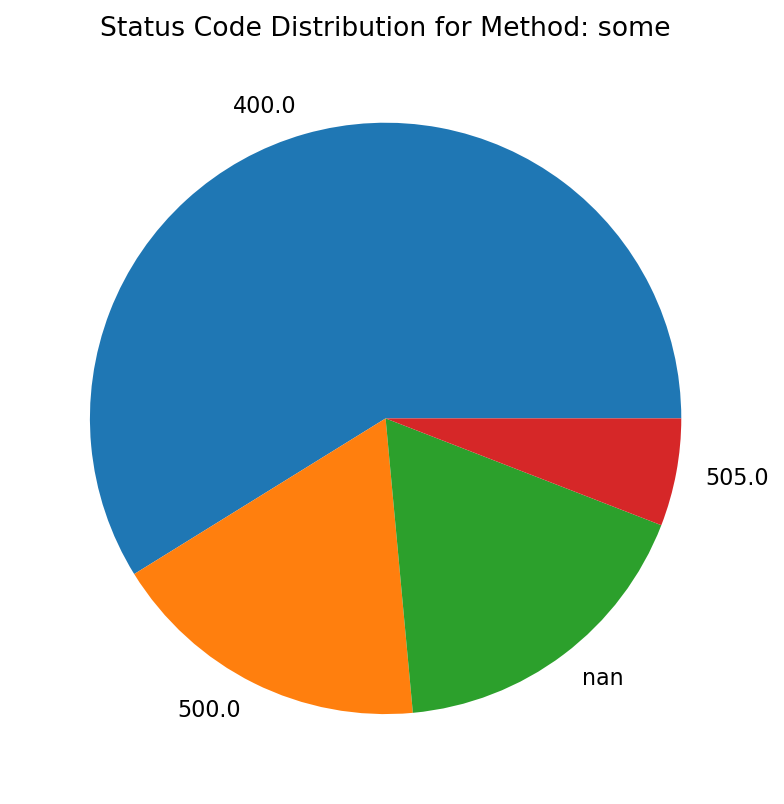

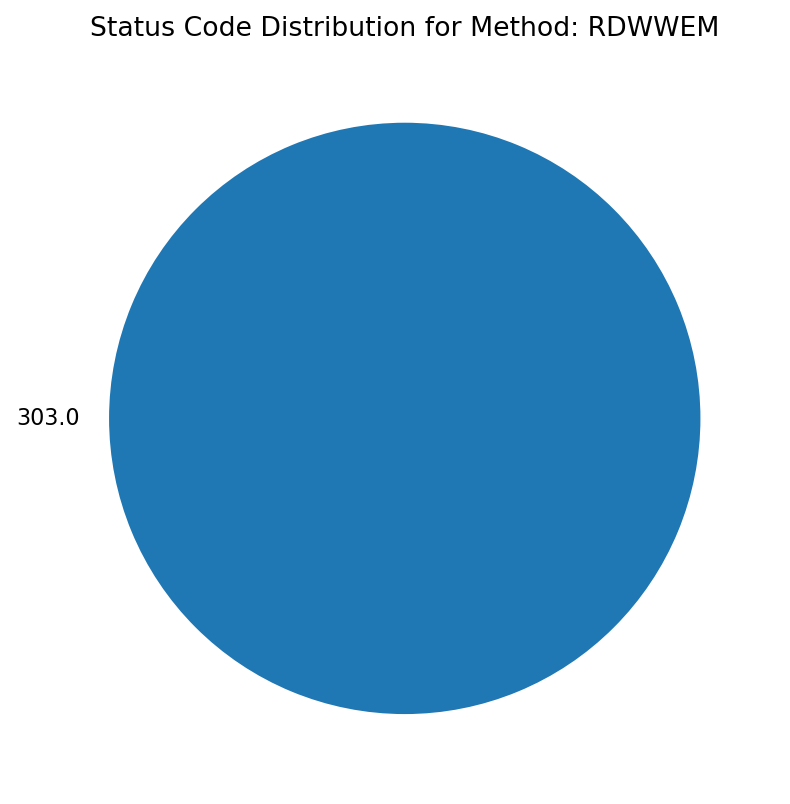

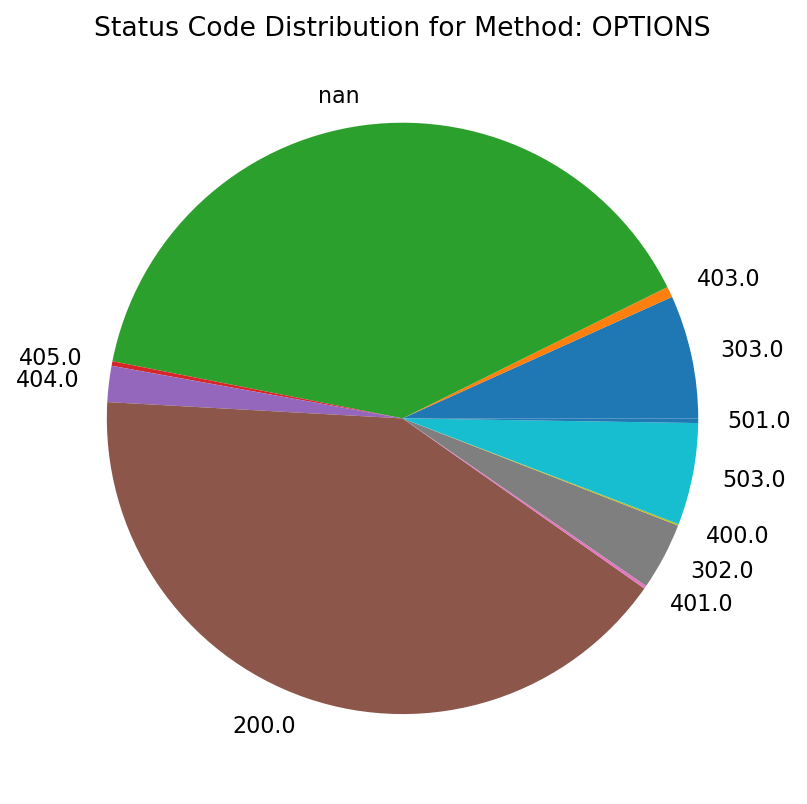

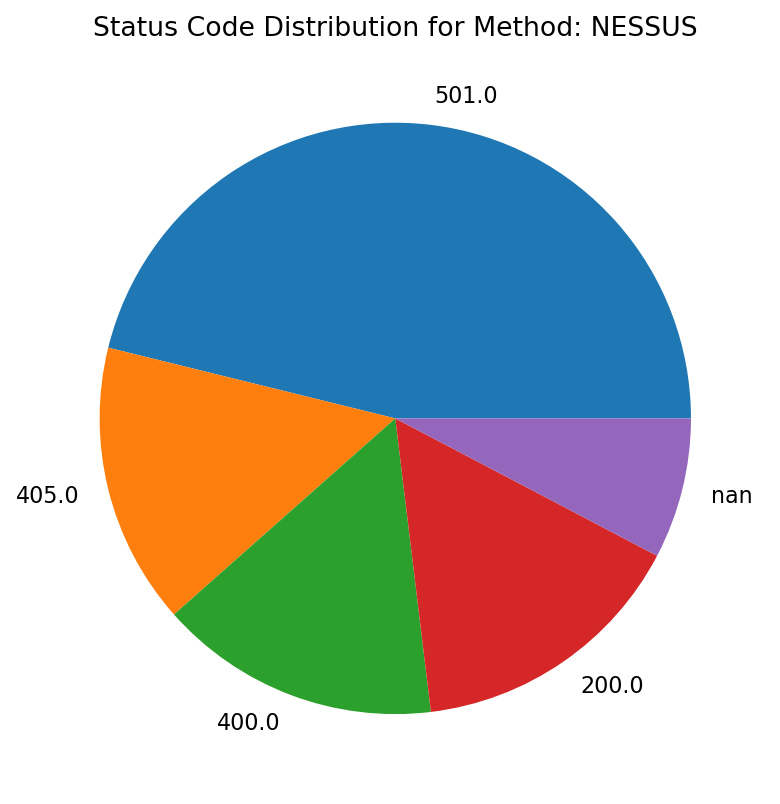

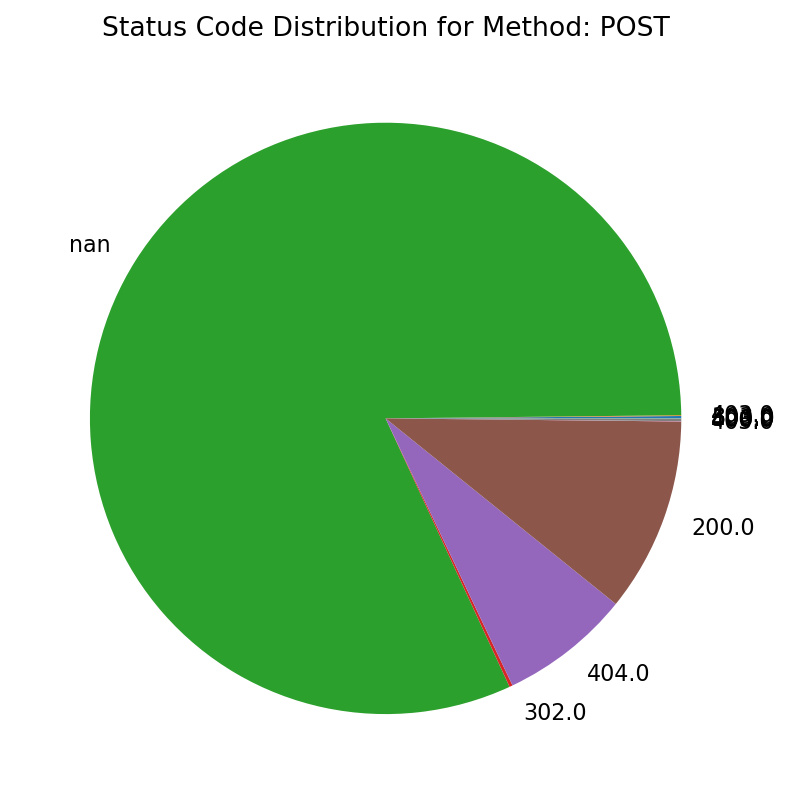

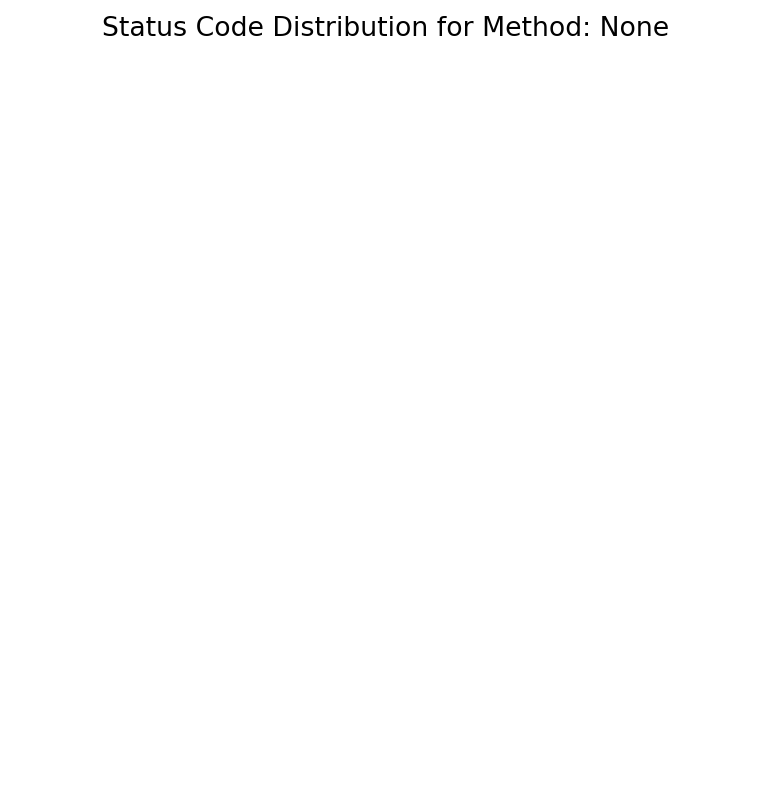

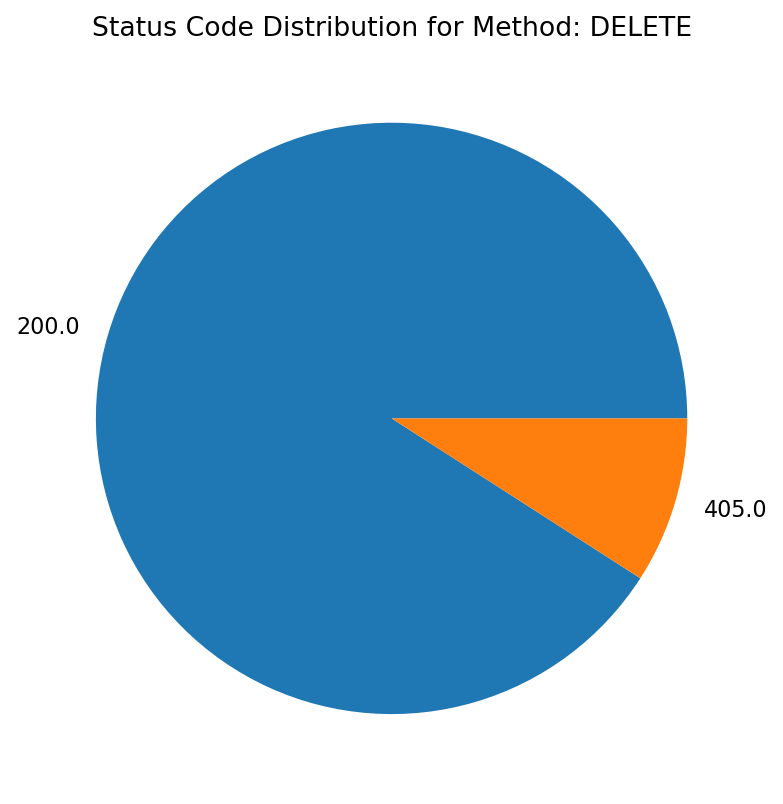

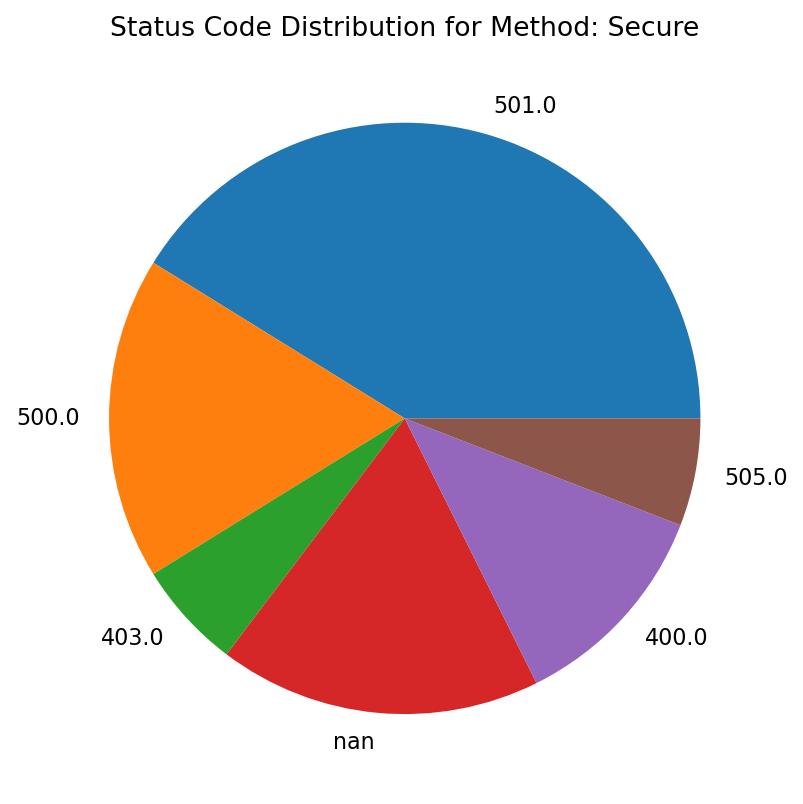

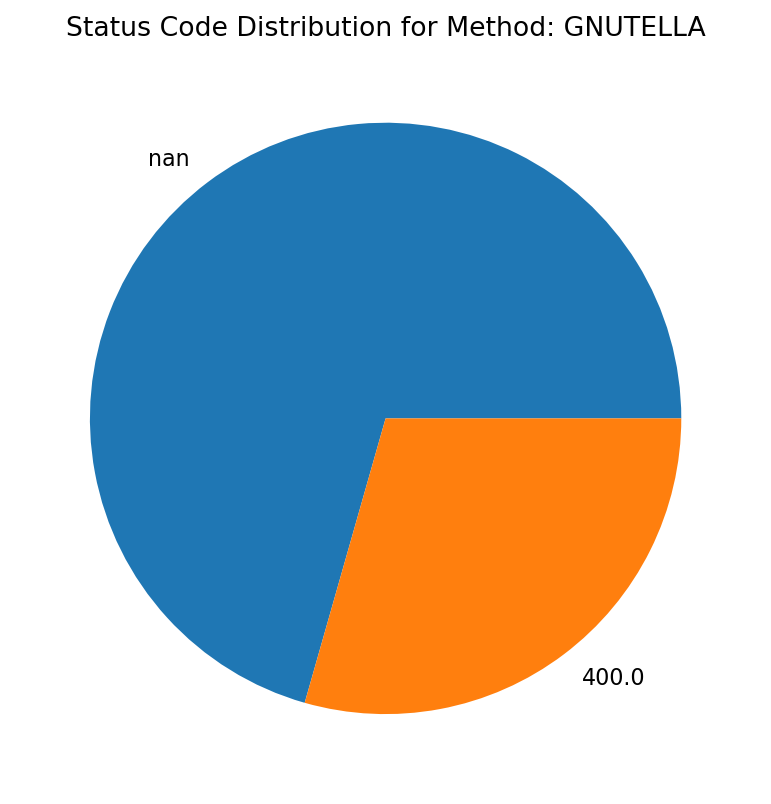

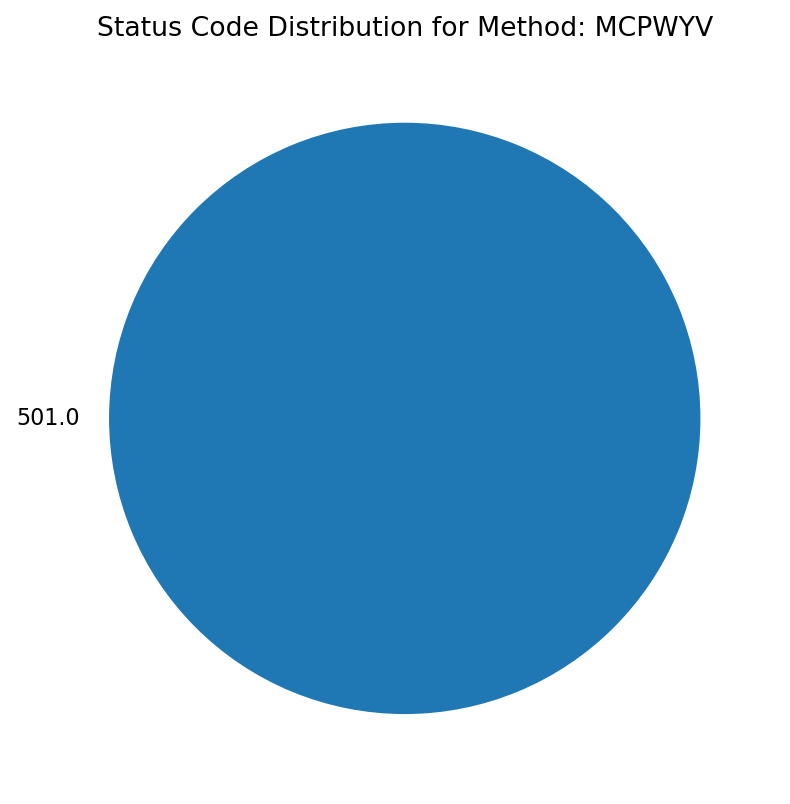

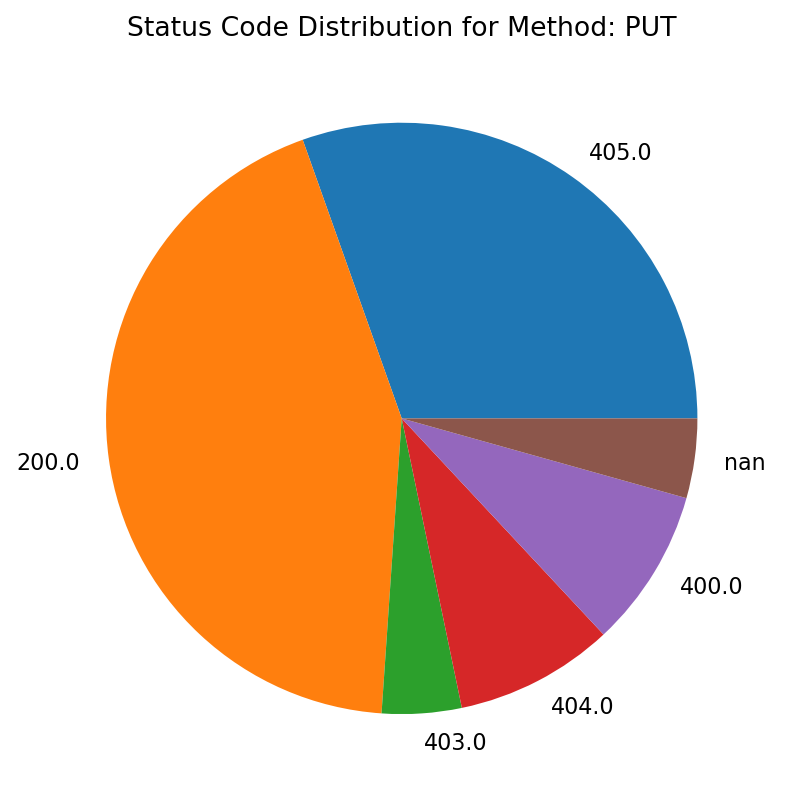

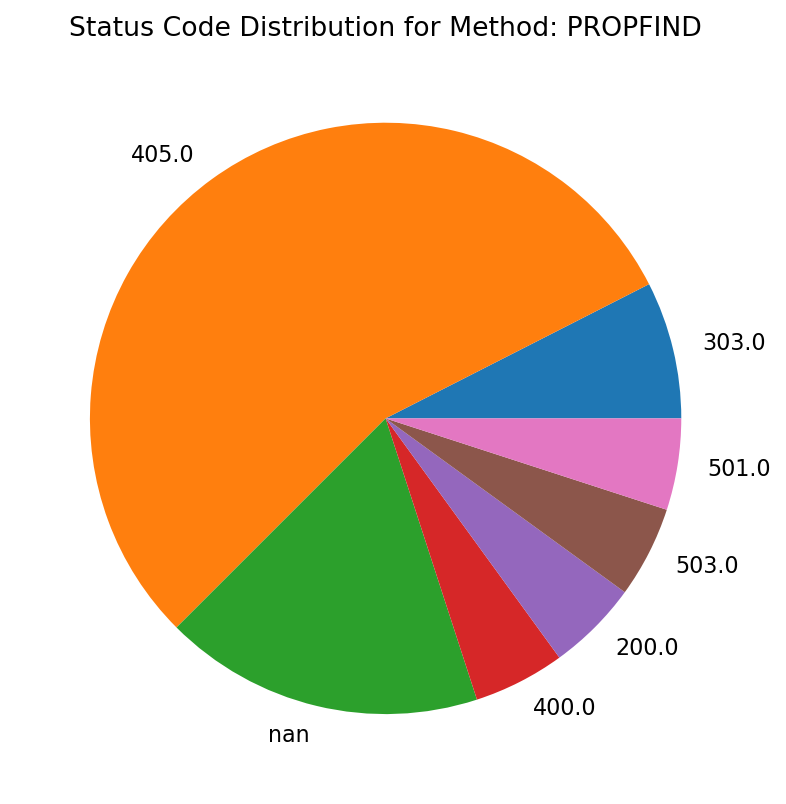

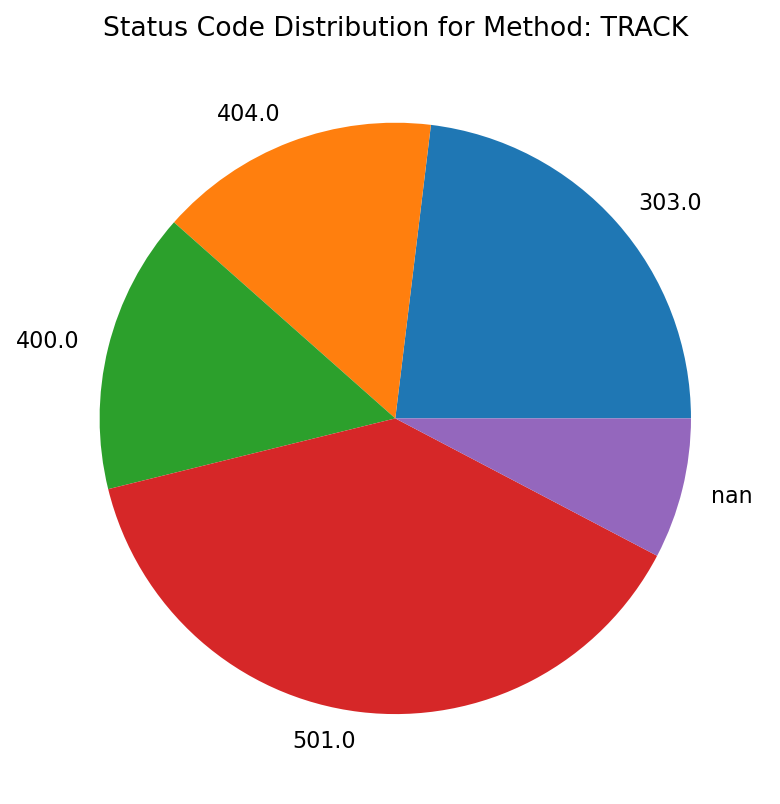

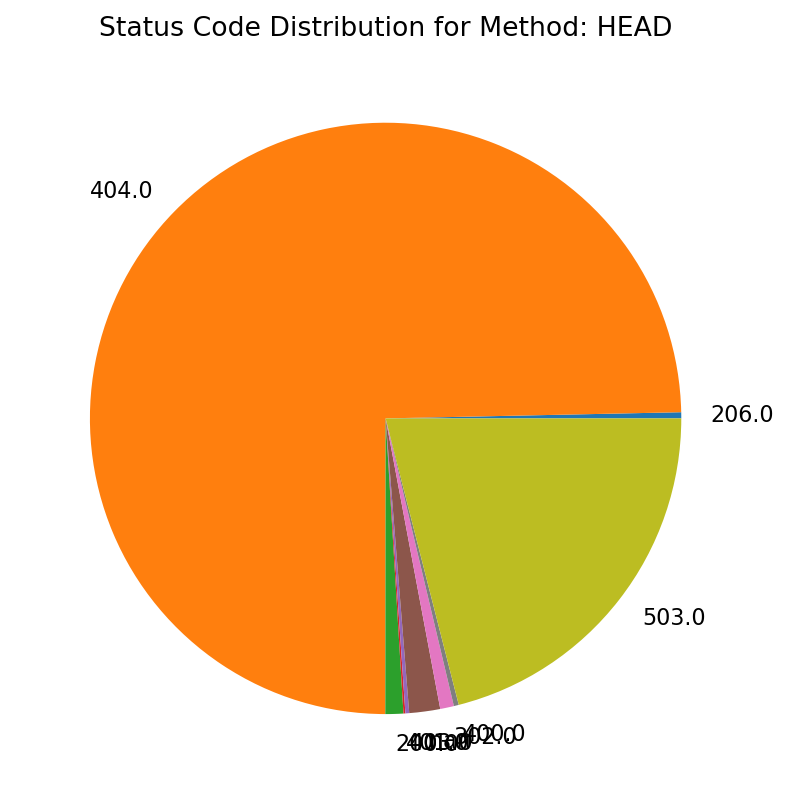

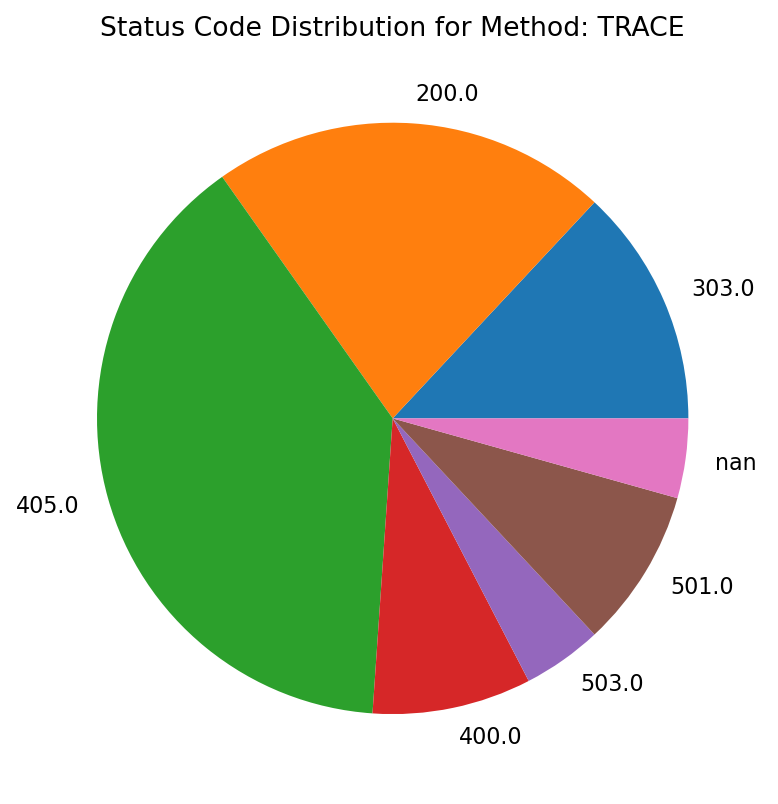

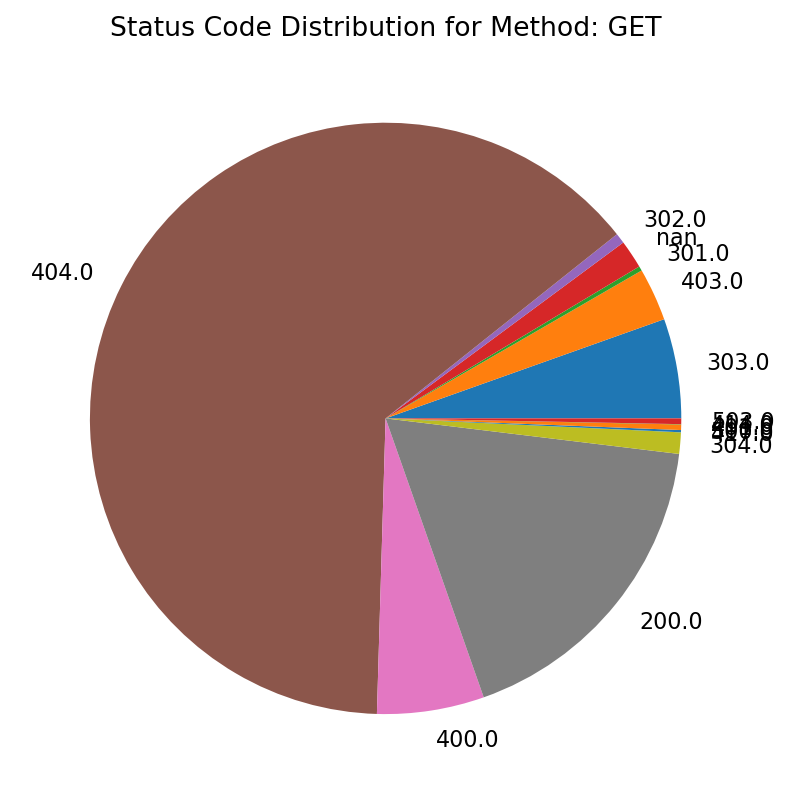

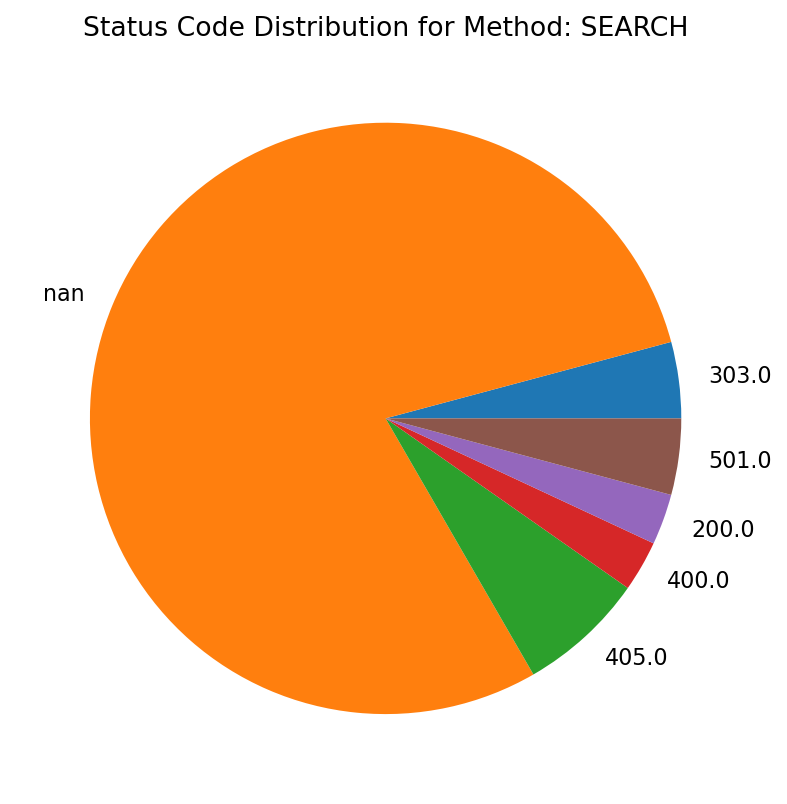

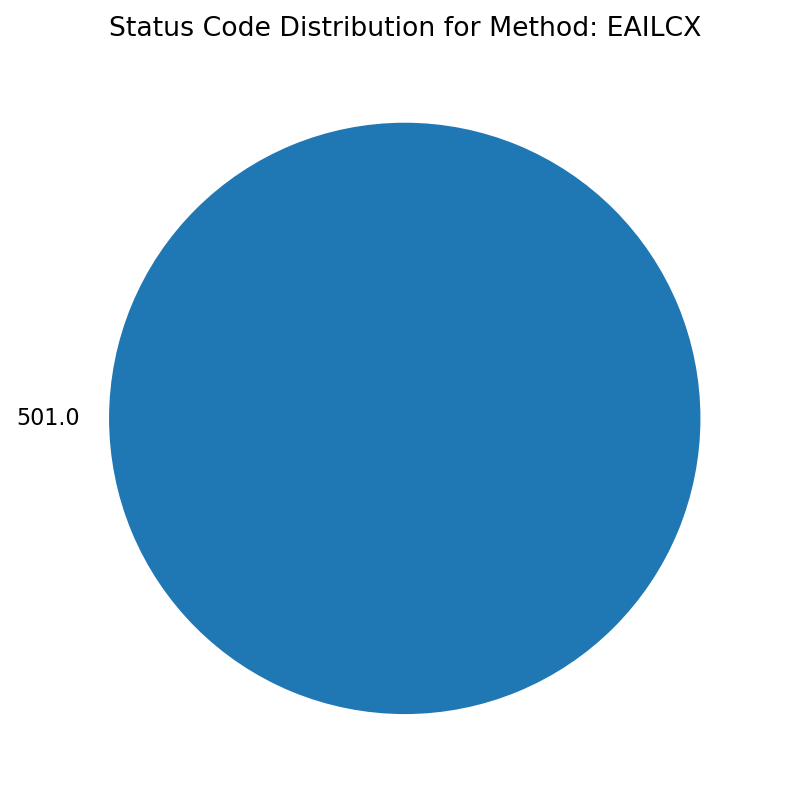

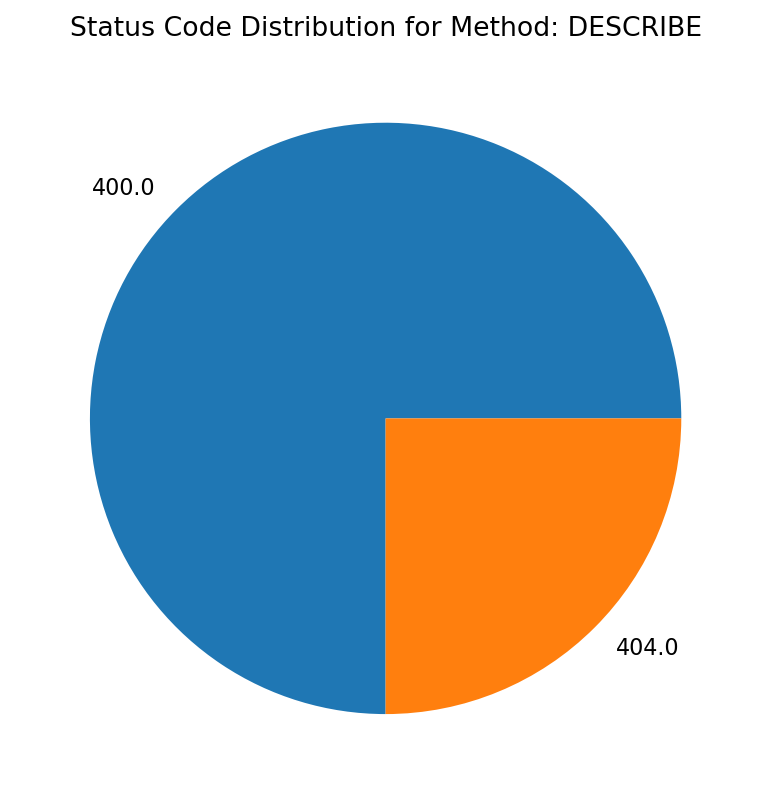

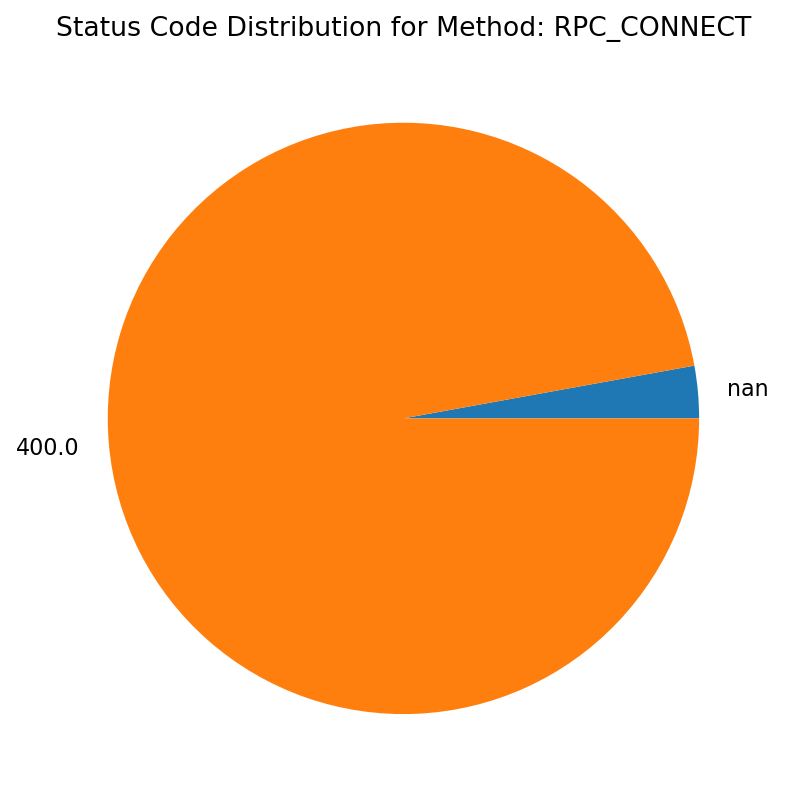

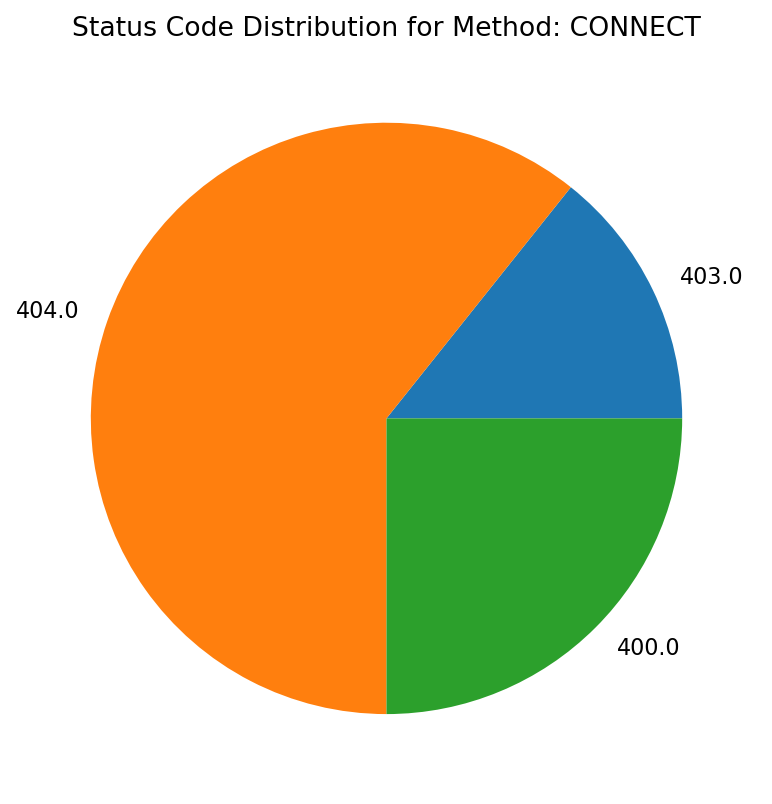

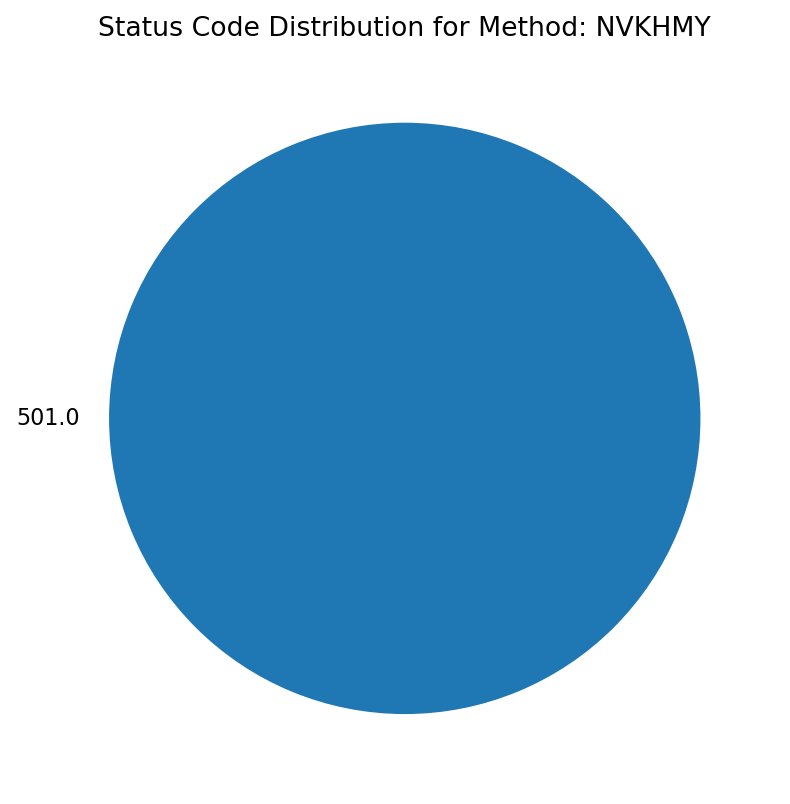

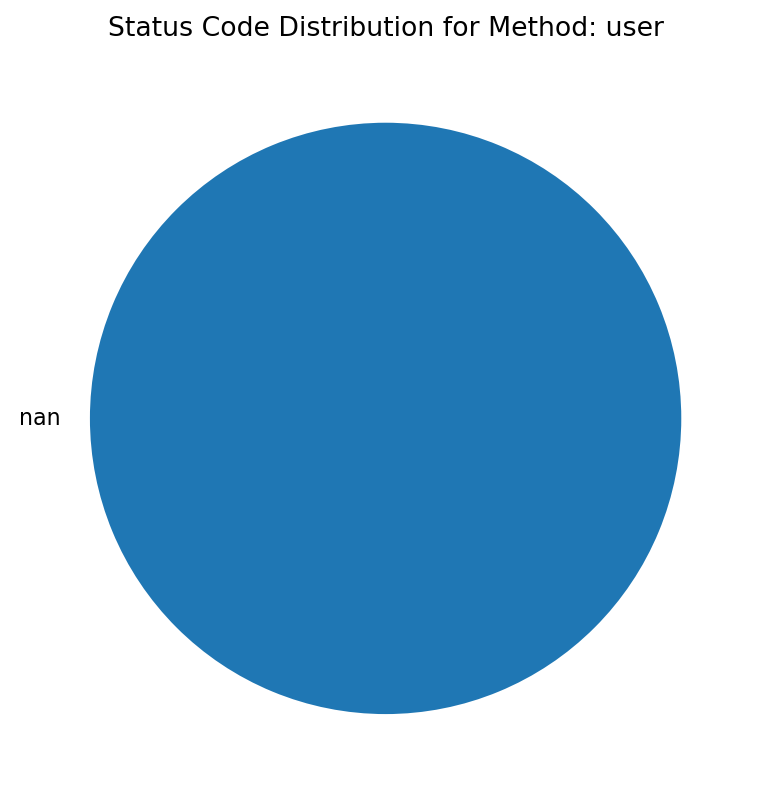

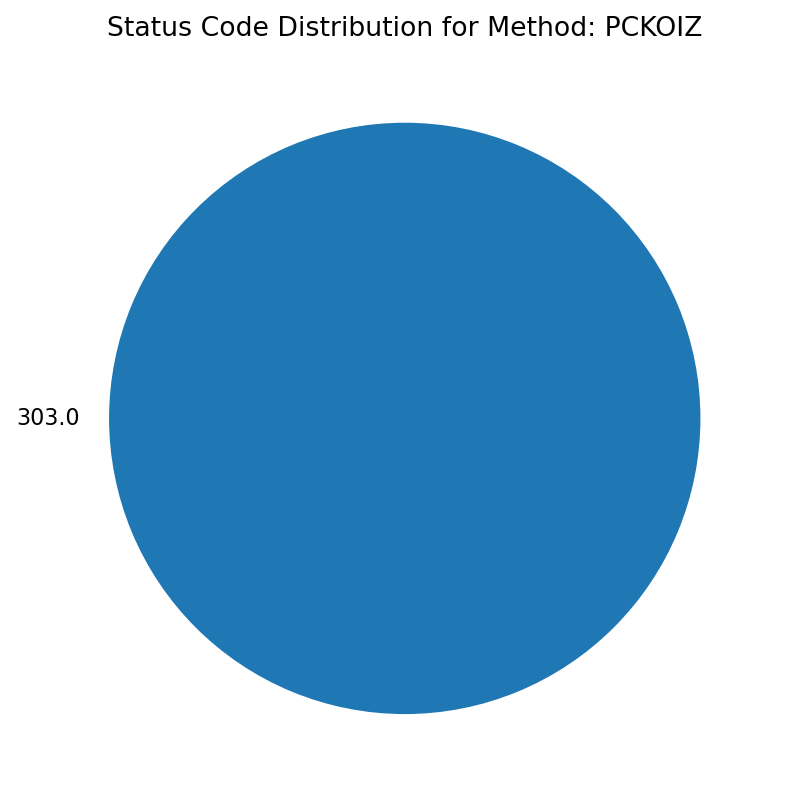

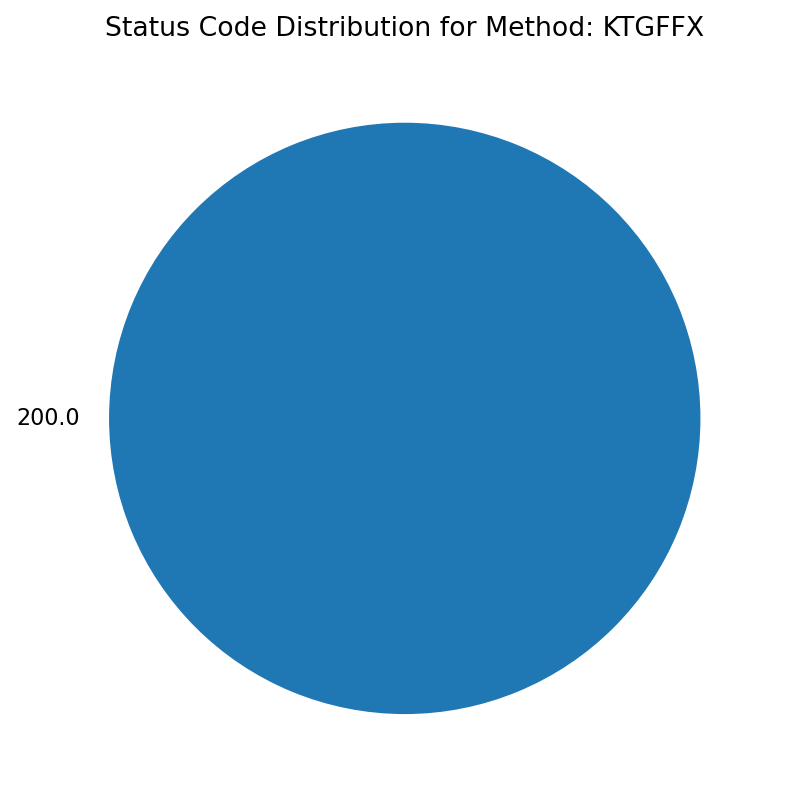

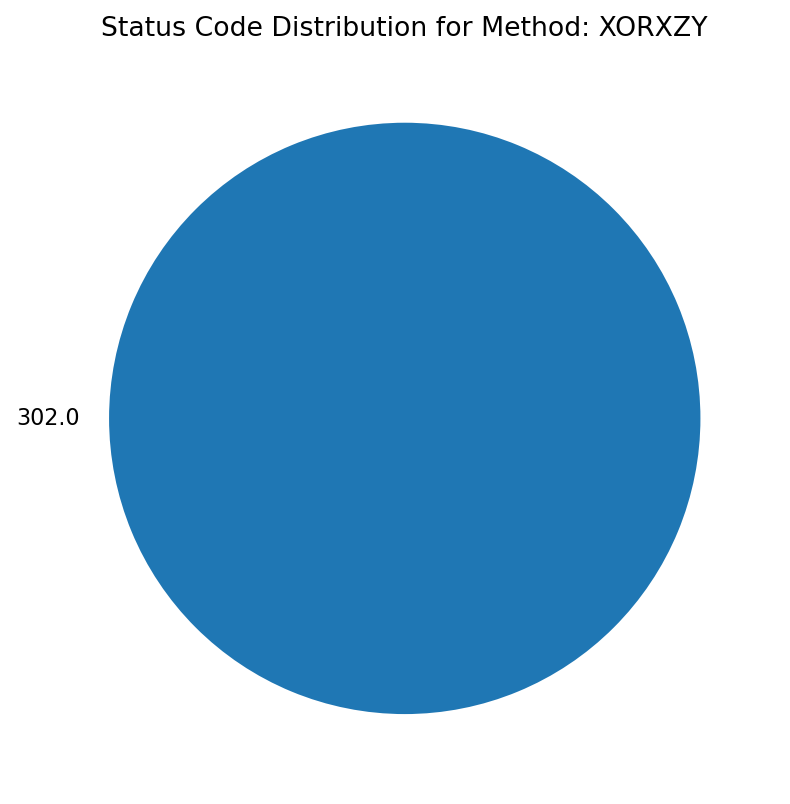

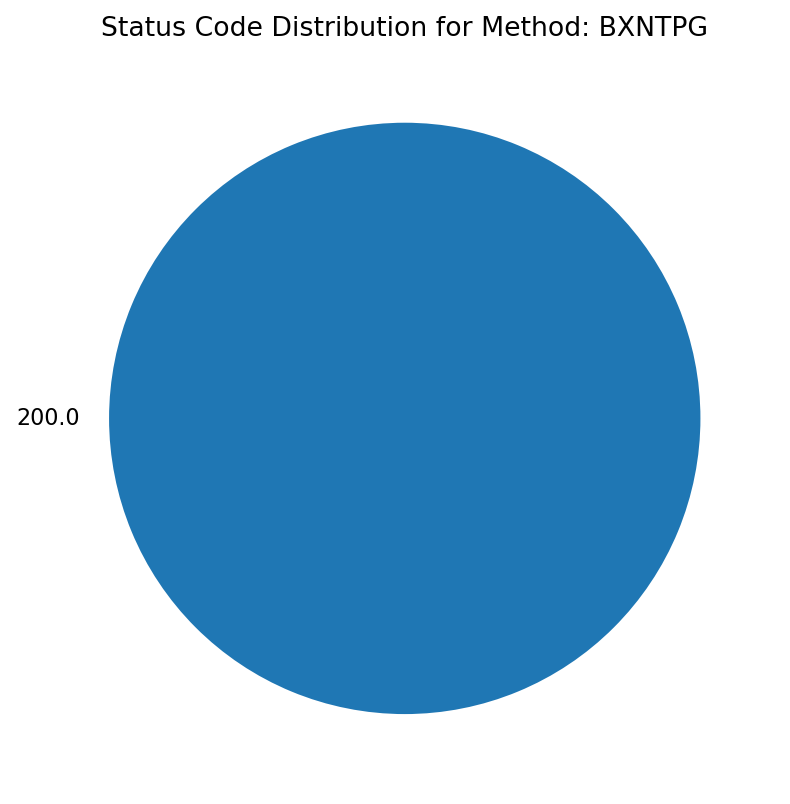

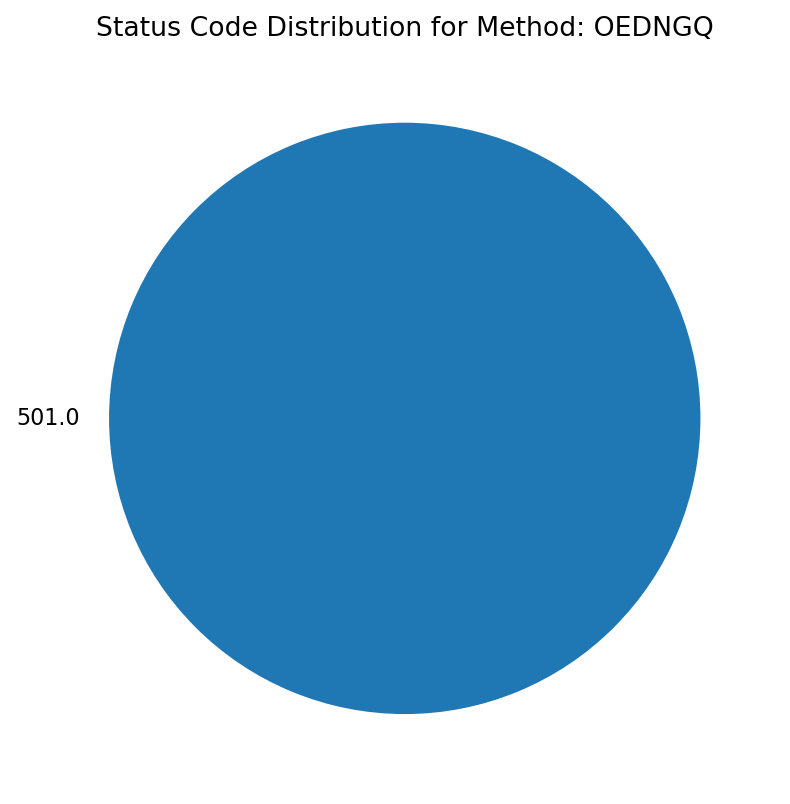

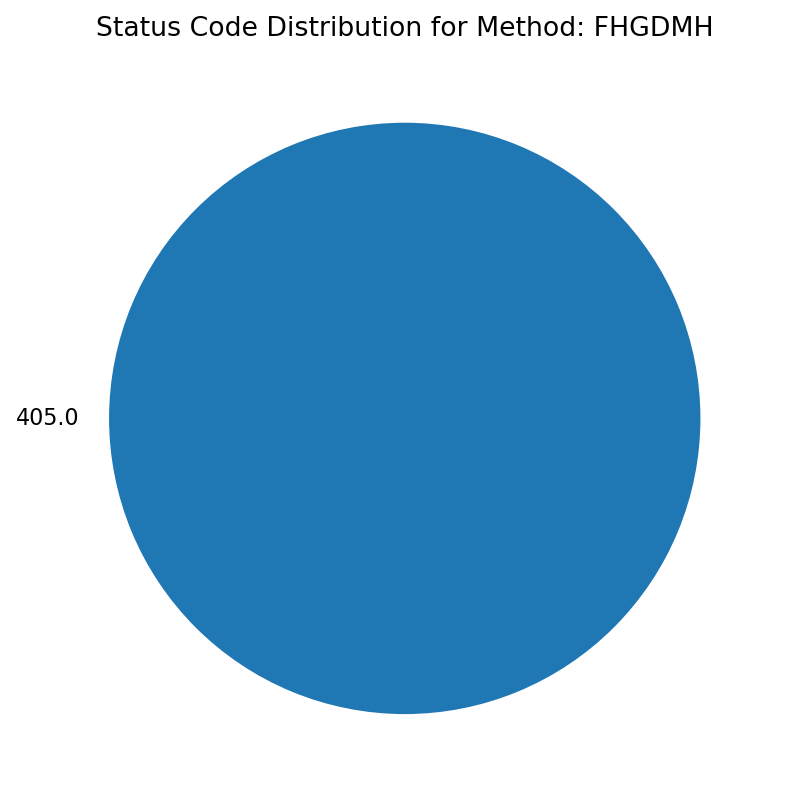

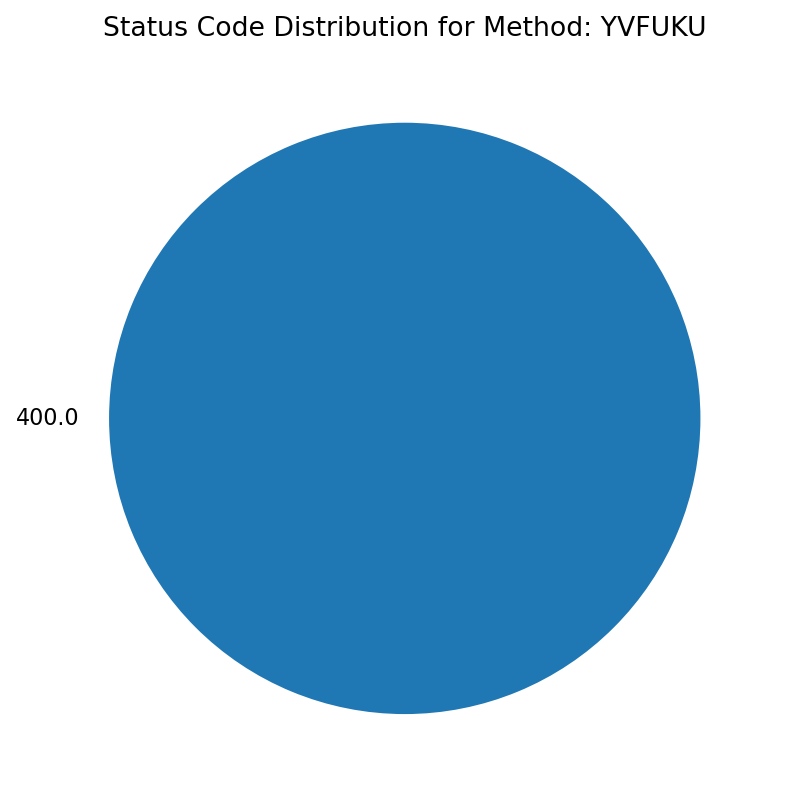

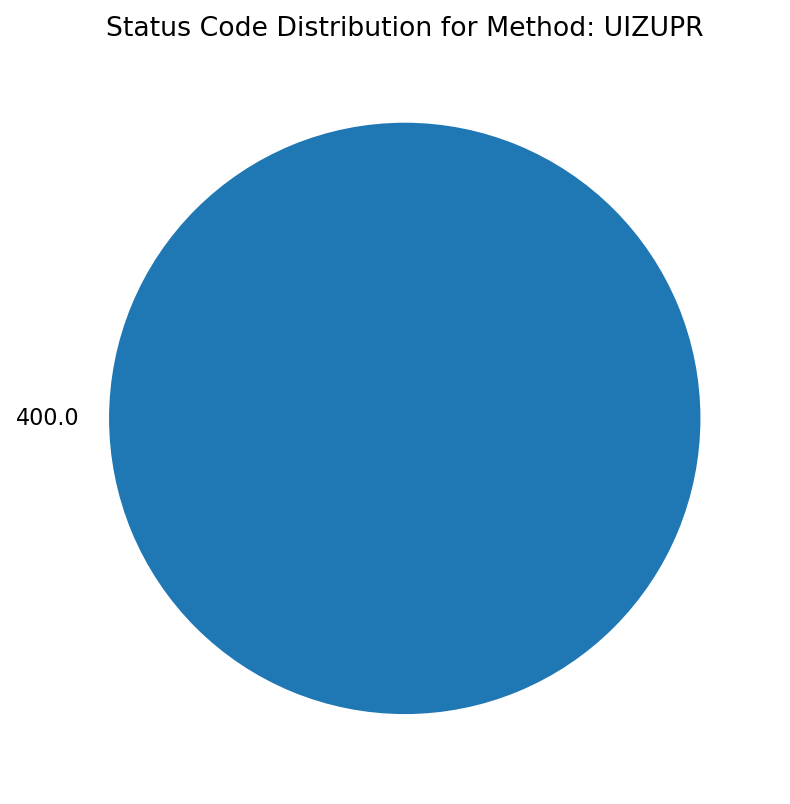

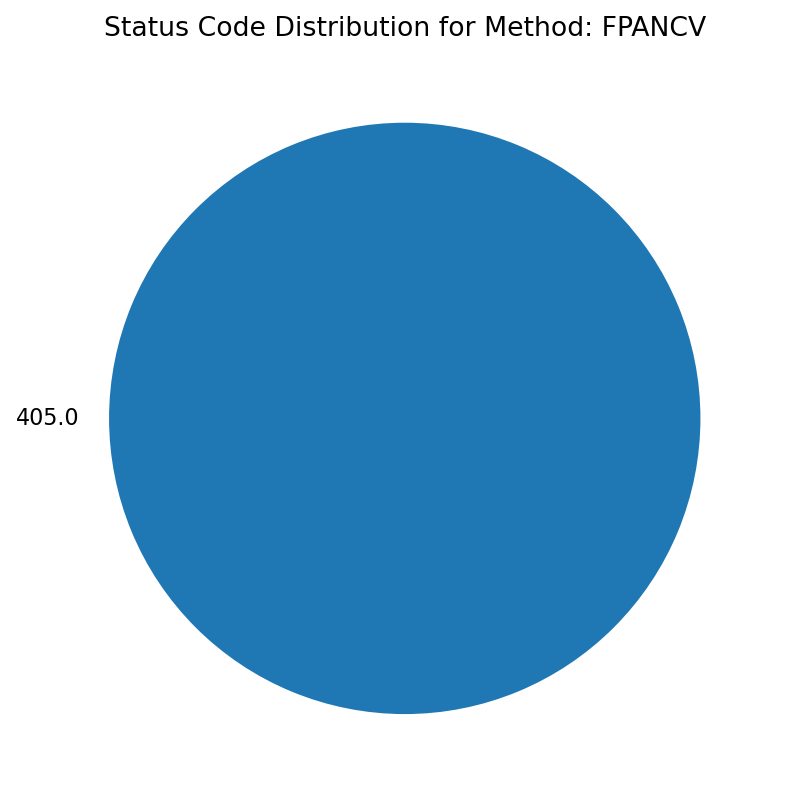

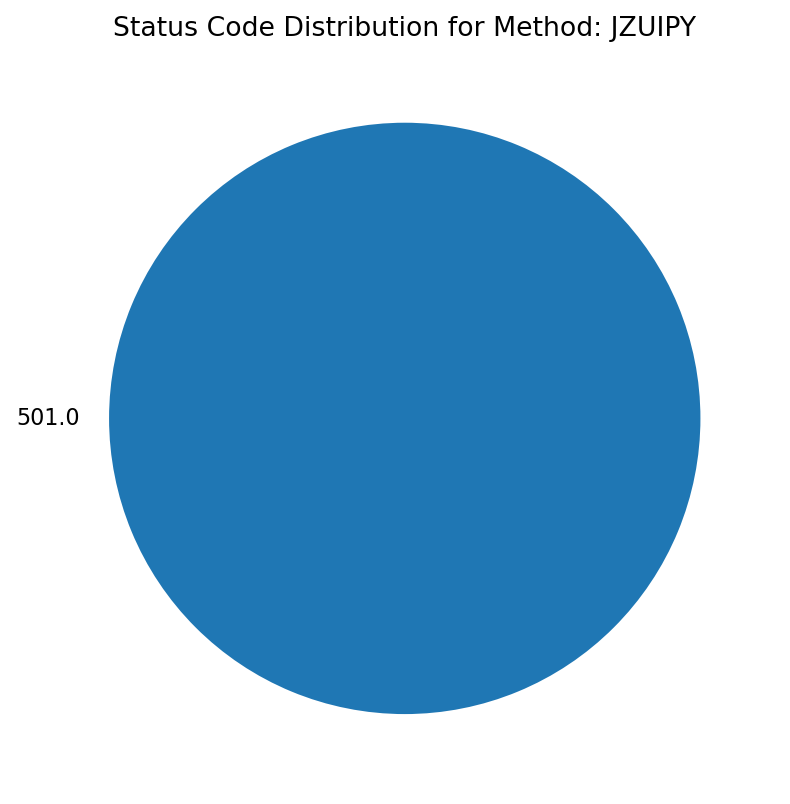

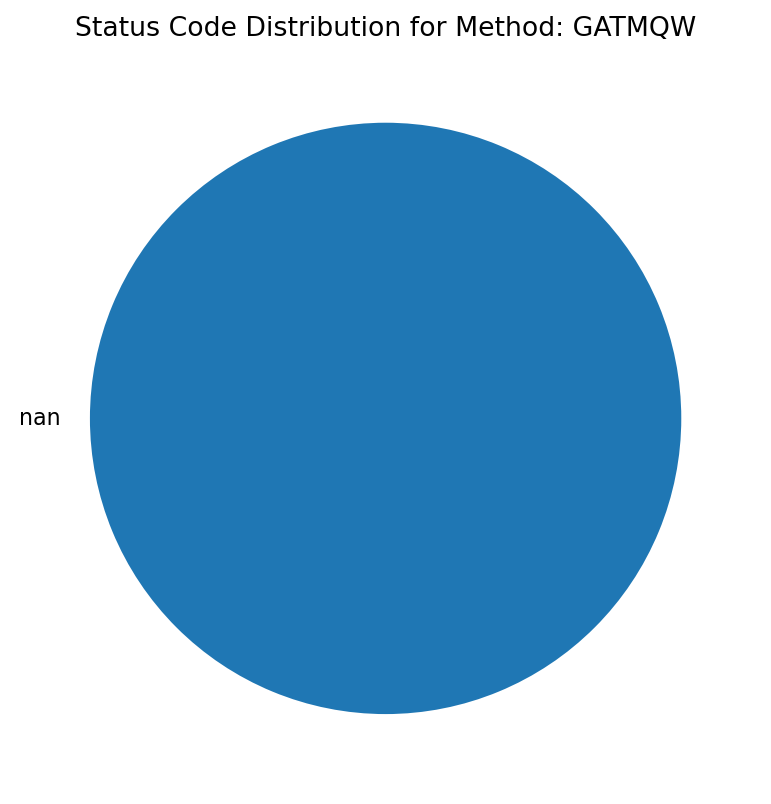

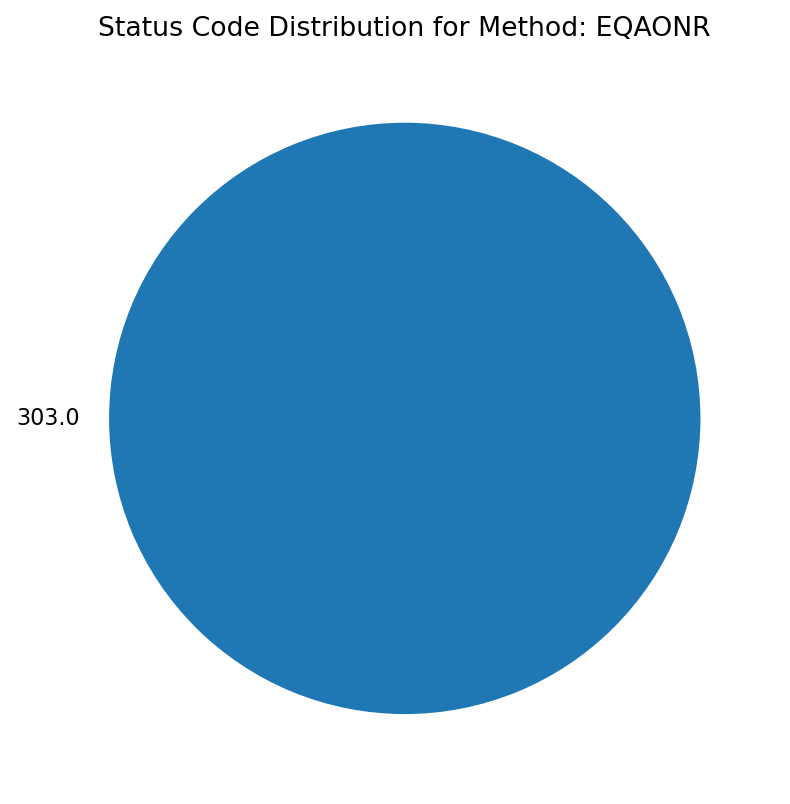

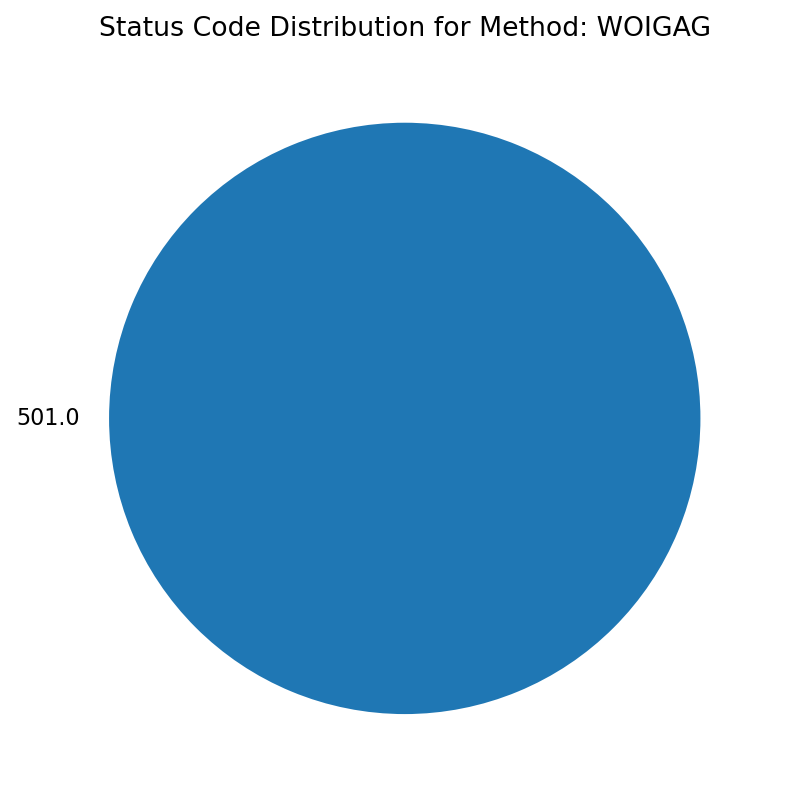

In [74]:
method_counts = df_http.groupBy("method").agg(count("*").alias("count"))

total_count = method_counts.selectExpr("sum(count) as total").collect()[0]["total"]

method_percentages = method_counts.withColumn("percentage", (col("count") / total_count) * 100)

method_percentages.show()

pie_data = method_percentages.toPandas()

for method in pie_data["method"]:
    method_df = df_http.filter(df_http["method"] == method)
    status_counts = method_df.groupBy("status_code").agg(count("*").alias("count"))
    status_data = status_counts.toPandas()
    plt.figure(figsize=(8, 6), dpi = 160)
    plt.pie(status_data["count"], labels=status_data["status_code"])
    plt.title(f"Status Code Distribution for Method: {method}")
    plt.savefig(f"./output/task1/pie_chart_{method}.png")
    plt.show()